# PyTorch完成Fashion-MNIST 分类

使用Fashion-MNIST数据集来创建一个神经网络模型。Fashion-MNIST是一组28x28的服装灰度图像，一共有十类。

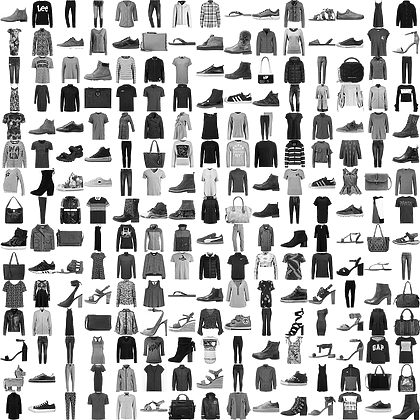

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, optim # optim here allow us to get optimizers
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # let us to use ReLU and log softmax
# import helper
from sklearn.metrics import confusion_matrix

In [6]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
print(torch. __version__)

1.10.0


## 1.图像变换和归一化，并将它们转换为张量

torchvision.transforms是pytorch中的图像预处理包。一般用Compose把多个步骤整合到一起

ToTensor()能够把灰度范围从0-255变换到0-1之间，

而后面的transform.Normalize()则把0-1变换到(-1,1).

In [8]:
transform = transforms.Compose([transforms.ToTensor(),   # ToTensor()能够把灰度范围从0-255变换到0-1之间
                                transforms.Normalize((0.5,), (0.5,))])  

## 2.加载数据集，创建训练集和测试集

通常有两种上传MNIST数据集的方法。1)加载csv文件和2)使用torchvision.datasets。这里使用了torchvision.dataset包

In [9]:
# Download and load the training data
trainset = torchvision.datasets.FashionMNIST('./data/MNIST_data/', download=True, train=True, transform=transform)

# Download and load the test data
testset = torchvision.datasets.FashionMNIST('./data/MNIST_data/', download=True, train=False, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST_data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST_data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST_data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST_data/FashionMNIST\raw



In [24]:
# 创建训练集和测试集数据加载器
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [25]:
# MNIST数据集类别
classes=('Tshirt', 'Trouser','Pullover', 'Dress', 'Coat',
        'Sandal','Shirt', 'Sneaker','Bag', 'Anke boot' )

### 2.1演示数据

In [26]:
def matplotlib_imshow (img, one_channel=False):
    if one_channel:
        img=im.mean(dim=0)
    img=img/2+0.5 # unnormalize
    npimg=img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))

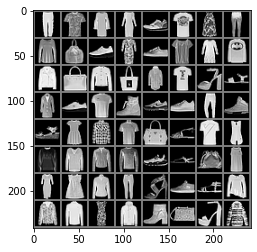

In [27]:
d=iter(trainloader)
images, labels=d.next()
matplotlib_imshow(torchvision.utils.make_grid(images))

9


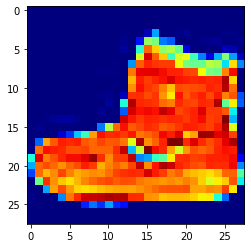

In [28]:
image, label=next(iter(trainset))
plt.imshow(image.squeeze(), cmap="jet")
print(label)

## 3.创建神经网络结构

In [29]:
# 四个全连接层
class Fashion(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Linear(784, 256)
        self.c2 = nn.Linear(256, 128)
        self.c3 = nn.Linear(128, 64)
        self.c4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = F.log_softmax(self.c4(x), dim=1)
        
        return x

## 4.训练网络


In [30]:
# 创建网络，定义误差、学习率和优化器
model = Fashion()

# 负对数似然损失函数，用于处理多分类问题，输入是对数化的概率值。
# 对于包含N个样本的batch数据 D(x, y)，x 是神经网络的输出，并进行归一化和对数化处理。y是样本对应的类别标签，每个样本可能是C种类别中的一个
error = nn.NLLLoss() 
learning_rate=0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# 训练网络
num_epochs = 500
for e in range(num_epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = error(log_ps, labels)
        optimizer.zero_grad() 
        loss.backward() # 反向传播
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}", end=" ")
        
    model.eval()
    with torch.no_grad():
        total=0
        correct=0
        for images,labels in testloader:
            log_ps=model(images)
            mx_index=torch.argmax(log_ps,dim=1)
            total+=labels.numel()
            correct+=sum(mx_index==labels).item()
        print(f"Test Accuracy {correct/total*100:.2f}")

Training loss: 0.5162448711327906 Test Accuracy 84.86
Training loss: 0.3788735897047942 Test Accuracy 86.01
Training loss: 0.3378255133991684 Test Accuracy 85.93
Training loss: 0.3118165480429684 Test Accuracy 87.01
Training loss: 0.2932007526760417 Test Accuracy 86.95
Training loss: 0.27474193529152413 Test Accuracy 87.19
Training loss: 0.2642721545133891 Test Accuracy 87.93
Training loss: 0.2502421015051446 Test Accuracy 87.92
Training loss: 0.23842054222629014 Test Accuracy 88.21
Training loss: 0.22736589441588248 Test Accuracy 88.26
Training loss: 0.21784144401677383 Test Accuracy 88.65
Training loss: 0.2089349797476075 Test Accuracy 88.38
Training loss: 0.1986580995370203 Test Accuracy 88.85
Training loss: 0.1920842885939297 Test Accuracy 88.57
Training loss: 0.1826610116085518 Test Accuracy 89.13
Training loss: 0.17830333203228235 Test Accuracy 88.96
Training loss: 0.16972098261046448 Test Accuracy 88.68
Training loss: 0.16293643284708198 Test Accuracy 88.21
Training loss: 0.1561

Training loss: 0.02485494889520436 Test Accuracy 88.67
Training loss: 0.022668420970465206 Test Accuracy 88.93
Training loss: 0.023207766017935054 Test Accuracy 89.07
Training loss: 0.028368534884781894 Test Accuracy 88.49
Training loss: 0.01726300245981213 Test Accuracy 89.11
Training loss: 0.03145635987383004 Test Accuracy 88.76
Training loss: 0.018615880940502694 Test Accuracy 88.78
Training loss: 0.022902751758842634 Test Accuracy 88.76
Training loss: 0.02162858105819237 Test Accuracy 89.16
Training loss: 0.022170444798693824 Test Accuracy 88.96
Training loss: 0.020178698669513436 Test Accuracy 88.58
Training loss: 0.0272927643184539 Test Accuracy 88.96
Training loss: 0.017704441303458864 Test Accuracy 88.97
Training loss: 0.025882810175869048 Test Accuracy 89.17
Training loss: 0.019378451795516366 Test Accuracy 88.99
Training loss: 0.028912483379137488 Test Accuracy 89.22
Training loss: 0.018753384657883485 Test Accuracy 88.86
Training loss: 0.028546094991140924 Test Accuracy 88.8

Training loss: 0.012597077849339937 Test Accuracy 88.96
Training loss: 0.017279686531552572 Test Accuracy 88.55
Training loss: 0.025295841029539964 Test Accuracy 88.73
Training loss: 0.009212423952527663 Test Accuracy 88.92
Training loss: 0.022881266494152716 Test Accuracy 88.69
Training loss: 0.015650464725512674 Test Accuracy 88.78
Training loss: 0.00943595754449616 Test Accuracy 88.58
Training loss: 0.021370696697782774 Test Accuracy 88.91
Training loss: 0.011662183002603226 Test Accuracy 88.70
Training loss: 0.014606380876003936 Test Accuracy 88.73
Training loss: 0.028725919028468657 Test Accuracy 89.31
Training loss: 0.00703027709343843 Test Accuracy 88.73
Training loss: 0.02122720656438966 Test Accuracy 88.62
Training loss: 0.013164302159294457 Test Accuracy 88.61
Training loss: 0.02370393511424619 Test Accuracy 88.90
Training loss: 0.013023159704901695 Test Accuracy 88.79
Training loss: 0.01455085800195965 Test Accuracy 89.34
Training loss: 0.022799799829686124 Test Accuracy 89.

Training loss: 0.006204822515488648 Test Accuracy 88.98
Training loss: 0.013919010749612565 Test Accuracy 88.51
Training loss: 0.024743356021469452 Test Accuracy 89.01
Training loss: 0.018810472022427534 Test Accuracy 89.03
Training loss: 0.005504764807494926 Test Accuracy 89.13
Training loss: 0.01856208111323189 Test Accuracy 88.63
Training loss: 0.009546650197964874 Test Accuracy 89.03
Training loss: 0.016161943957959272 Test Accuracy 89.28
Training loss: 0.016205562493411752 Test Accuracy 89.35
Training loss: 0.01736534322859552 Test Accuracy 88.95
Training loss: 0.005268958865971868 Test Accuracy 89.23
Training loss: 0.017119616941312636 Test Accuracy 89.03
Training loss: 0.01838563394401625 Test Accuracy 88.83
Training loss: 0.013350533229116527 Test Accuracy 89.15
Training loss: 0.014107692902115028 Test Accuracy 89.30
Training loss: 0.01634945679286177 Test Accuracy 88.98
Training loss: 0.00821301217709167 Test Accuracy 89.17
Training loss: 0.017114510956816657 Test Accuracy 89.

tensor([[1.9012e-13, 9.3125e-35, 8.1853e-18, 1.6048e-19, 7.0297e-12, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0427e-25, 0.0000e+00]],
       grad_fn=<ExpBackward0>)


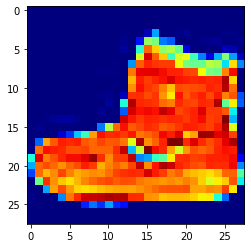

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[5]
ps=torch.exp(model(img))
plt.imshow(image.squeeze(), cmap="jet")
print(ps)
# plt.

AttributeError: module 'helper' has no attribute 'view_classify'